In [9]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## First we need to define some things. user/passwd, etc.

In [10]:
targetNumDates = 5 #may be able to increase this if you are using less than a full frame (<9-10 bursts, <3 swaths)
workdir  ='/home/jovyan/CV' #make sure this exists
dem      = '/home/jovyan/CV/dem/demLat_N34_N37_Lon_W118_W121.dem.wgs84' #make sure this exists too!

## Fix Paths
Do this if you haven't already - will have to close and restart this notebook.

## Go to vertex and do an initial search
You should narrow down your area of interest, and which track you are using. Choose a bounding box (draw on map) - all frames that even touch it will be downloaded, so take some care in choosing a reasonable bounds
Paste in the "wkt" format lat/lon bounds from vertex, and set your track and other info below.

In [11]:
polygon = "&intersectsWith=POLYGON((-120.22 35.74,-119.25 35.74,-119.25 36.24,-120.22 36.24,-120.22 35.74))"
track   = "&relativeOrbit=144" #also referred to as "relative orbit"
date1   = '&start=2019-08-14'  #start of search date period
date2   = '&end=2021-09-30'    #end of search date period
refdate = '20190814'
pltdate = '20190820_20190826' #pair that you will plot in a later step

narrowpoly = ' -b \'35.74 36.24 -120.22 -119.25\' ' #this is the area you want to extract, but may need be adjusted after your first iter of stackSentinel_VH
swaths     = ' -n \'1 2 3\''    #list of swaths if you know you only need one or two, otherwise all.
looks      = ' -r 20 -z 4 ' #final looks of your large-area interferograms
croppoly   = [5000, 2000, 30000, 3500] #UL corner, width and length


## Run api calls to construct list of files

In [29]:
#this is a dumb way of doing this, but I don't feel like dealing with installing the requests package.
apistring='https://api.daac.asf.alaska.edu/services/search/param?platform=S1&beamSwath=IW&processingLevel=SLC'+track+date1+date2+polygon
os.system('wget \"'+apistring+'&output=csv\" -O '+workdir+'/list.csv -q')


0

In [12]:
df = pandas.read_csv(workdir+'/list.csv')
df['Acquisition Date'] = pandas.to_datetime(df['Acquisition Date'])
df['date'] = pandas.to_datetime(df['Acquisition Date'])    
numfiles = np.shape(df)[0]

uniqueDates=df['date'].dt.date.unique()
uniqueDates.sort()
totNumDates=np.size(uniqueDates)
print(str(totNumDates)+ ' unique dates and ' + str(numfiles) +' total files')

coregSLCDir = os.path.join(workdir, 'coreg_secondarys/vv') #look in vv since that should be complete
if os.path.exists(coregSLCDir):
    coregSecondarys = glob.glob(os.path.join(coregSLCDir, '[0-9]???[0-9]?[0-9]?'))
    coregSLC = [os.path.basename(slv) for slv in coregSecondarys]
    coregSLC.sort()

    if len(coregSLC)>0:
        print('It looks like the following dates have already been done')
        print(coregSLC)
        index=len(coregSLC)
        print('Starting on date: '+str(uniqueDates[index]))
        remNumDates = totNumDates-len(coregSLC)

    else:
        index=0
        remNumDates = totNumDates

else:
    index=0
    remNumDates = totNumDates

batches = int(np.ceil(remNumDates / targetNumDates))
print(str(batches)+' batches with '+str(targetNumDates)+ ' dates each')

129 unique dates and 129 total files
It looks like the following dates have already been done
['20190814', '20190820', '20190826', '20190901', '20190907', '20190913', '20190919', '20190925']
Starting on date: 2019-10-01
25 batches with 5 dates each


## First batch
Now we have a list of files so we will try our first batch, which should contain your first (reference) date as set above.  I think this SHOULD now find all files on a given date.  That part was a pain.

In [6]:
i=0
print('Downloading data for batch '+str(int(i)))
for j in np.arange(targetNumDates):
    if index < totNumDates:
        for k in np.arange(numfiles):
             if df.date[k].date() == uniqueDates[index]:
                    rawFile=df['URL'][k]
                    rawRoot=os.path.basename(rawFile)
                    if os.path.exists(os.path.join('/home/jovyan',workdir,'raw',rawRoot)):
                        print(rawRoot+' already downloaded')
                    else:
                        print('Downloading '+rawRoot)
                        wstr='wget '+ rawFile + ' --directory-prefix=' + workdir + '/raw'
                        os.system(wstr+' -q  --show-progress  --progress=bar:force:noscroll')
        
        index+=1
    

S1A_IW_SLC__1SDV_20190814T140002_20190814T140029_028566_033B15_C658.zip already downloaded
S1B_IW_SLC__1SDV_20190820T135928_20190820T135955_017670_0213E6_8ABA.zip already downloaded
S1A_IW_SLC__1SDV_20190826T140003_20190826T140030_028741_034120_E9C4.zip already downloaded


## prepping and running stack

In [7]:
command='stackSentinel_VH.py -s '+workdir+'/raw -m '+refdate+' -o /home/jovyan/ -a '+workdir+'/aux/ -w '+workdir+' -d '+dem+narrowpoly+swaths+looks+' -c 1 -O 1 -W interferogram'
print(command)
os.system(command)

stackSentinel_VH.py -s /home/jovyan/CV/raw -m 20190814 -o /home/jovyan/ -a /home/jovyan/CV/aux/ -w /home/jovyan/CV -d /home/jovyan/CV/dem/demLat_N34_N37_Lon_W118_W121.dem.wgs84 -b '35.74 36.24 -120.22 -119.25'  -n '1 2 3' -r 20 -z 4  -c 1 -O 1 -W interferogram
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Number of SAFE files found: 7
*****************************************
20190826
orbit was not found in the /home/jovyan
downloading precise or restituted orbits ...
restituted orbit already exists.
2021-11-05 23:10:08,742 - shapely.geos - DEBUG - Trying `CDLL(libc.so.6)`
2021-11-05 23:10:08,744 - shapely.geos - DEBU

0

## Check output 
Did it run and make run_files and runstuff and runstuff2?  Did all the dates get selected?  often need to adjust the -b parameter here.

## Next, run the "runstuff" command that runs all the subroutines making the stack

In [5]:
os.system(workdir+'/runstuff  > errors 2> extraerrors')

0

## Check output
Did everything run?  Is there content in the merged directory?  If so, now is the time to pick your cropping locations.

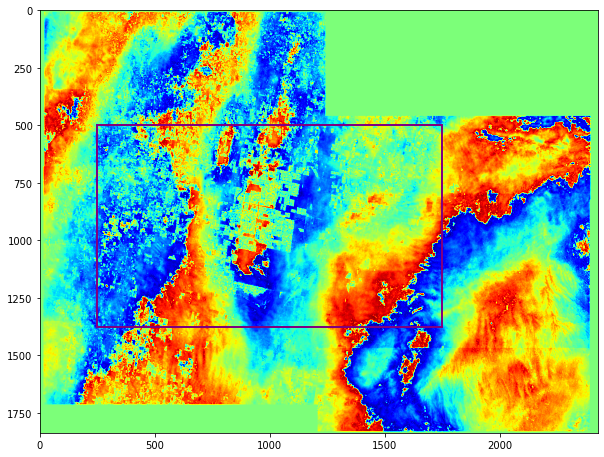

In [15]:
#bounds of our cropped region
x1=int(croppoly[0]/20)
x2=int((croppoly[0]+croppoly[2])/20)
y1=int(croppoly[1]/4)
y2=int((croppoly[1]+croppoly[3])/4)

ds = gdal.Open(workdir+"/merged/interferograms/"+pltdate+"/fine.int", gdal.GA_ReadOnly)
data_array = ds.GetRasterBand(1).ReadAsArray()

ang_data_array= np.angle(data_array)
abs_data_array= np.abs(data_array)
plt.figure(figsize=(10, 11))
plt.imshow(ang_data_array,vmin=-np.pi, vmax=np.pi, cmap='jet')
#plt.imshow(abs_data_array,vmin=0, vmax=10000, cmap='gray', origin='upper')
rect=mpatches.Rectangle((x1,y1),(x2-x1),(y2-y1), 
                        fill=False,
                        color="purple",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)

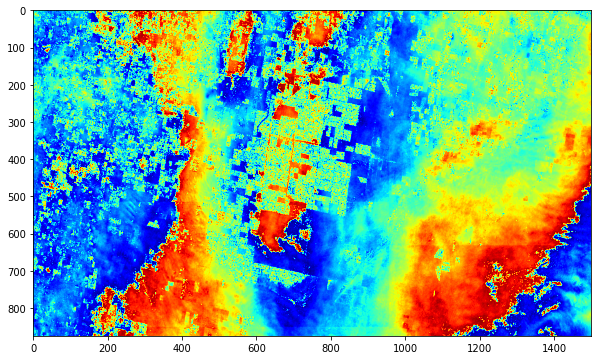

In [16]:
plt.figure(figsize=(10, 11))
plt.imshow(ang_data_array[y1:y2,x1:x2],vmin=-np.pi, vmax=np.pi, cmap='jet')

## Crop and delete
Next we run runstuff 2 - be careful, since what it does is crop and then delete files!

In [6]:
os.system(workdir+'/runstuff2')
#os.system('python cropAll.py')

cropping /home/jovyan/CV/merged/SLC_vv/20190901/20190901.slc.full
cropping /home/jovyan/CV/merged/SLC_vv/20190814/20190814.slc.full
cropping /home/jovyan/CV/merged/SLC_vv/20190919/20190919.slc.full
cropping /home/jovyan/CV/merged/SLC_vv/20190907/20190907.slc.full
cropping /home/jovyan/CV/merged/SLC_vv/20190913/20190913.slc.full
cropping /home/jovyan/CV/merged/SLC_vv/20190925/20190925.slc.full
cropping /home/jovyan/CV/merged/SLC_vh/20190901/20190901.slc.full
cropping /home/jovyan/CV/merged/SLC_vh/20190919/20190919.slc.full
cropping /home/jovyan/CV/merged/SLC_vh/20190907/20190907.slc.full
cropping /home/jovyan/CV/merged/SLC_vh/20190913/20190913.slc.full
cropping /home/jovyan/CV/merged/SLC_vh/20190925/20190925.slc.full
cropping /home/jovyan/CV/merged/geom_reference/los.rdr.full
cropping /home/jovyan/CV/merged/geom_reference/lat.rdr.full
cropping /home/jovyan/CV/merged/geom_reference/lon.rdr.full
cropping /home/jovyan/CV/merged/geom_reference/hgt.rdr.full


0

In [7]:
i=1
#os.system('/home/jovyan/CV/run_files/run_16_deleteThings')
#move old runfiles+errors to a new directory
os.rename(workdir+'/run_files',workdir+'/run_files'+str(i))
os.rename(workdir+'/runstuff',workdir+'/run_files'+str(i)+'/runstuff')
os.rename(workdir+'/runstuff2',workdir+'/run_files'+str(i)+'/runstuff2')

sh: 1: /home/jovyan/CV/run_files/run_16_deleteThings: not found


## If you are content with what comes out, let's run the rest of the batches.
Exploring use of 'stackLoop.py' instead 

In [14]:
i=1
#username='kdevlin525'
#passwd='mKl09as098='
for i in np.arange(i+1,batches):
    print('Starting batch '+str(int(i)))
    for j in np.arange(targetNumDates):
        if index < totNumDates:
            for k in np.arange(numfiles):
                 if df.date[k].date() == uniqueDates[index]:
                    rawFile=df['URL'][k]
                    rawRoot=os.path.basename(rawFile)
                    if os.path.exists(os.path.join(workdir,'raw',rawRoot)):
                        print(rawRoot+' already downloaded')
                    else:
                        print('Downloading '+rawRoot)
                        #wstr='wget '+ rawFile+ ' --user="' + username + '" --password="' + passwd + '" --directory-prefix=' + workdir + '/raw'
                        wstr='wget '+ rawFile+' --directory-prefix=' + workdir + '/raw'
                        os.system(wstr+' -q  --show-progress  --progress=bar:force:noscroll')
 
            index+=1
    
    command='stackSentinel_VH.py -s '+workdir+'/raw -m '+refdate+' -o /home/jovyan/ -a '+workdir+'/aux/ -w '+workdir+' -d '+dem+narrowpoly+swaths+looks+' -c 1 -O 1 -W interferogram'
    os.system(command)
    os.system(workdir+'/runstuff  > errors 2> extraerrors')
    os.system(workdir+'/runstuff2')
    os.rename(workdir+'/run_files',workdir+'/run_files'+str(i))
    os.rename(workdir+'/runstuff',workdir+'/run_files'+str(i)+'/runstuff')
    os.rename(workdir+'/runstuff2',workdir+'/run_files'+str(i)+'/runstuff2')

Starting batch 2


S1B_IW_SLC__1SDV_20 100%[===================>]   4.07G  64.0MB/s    in 1m 40s  


S1A_IW_SLC__1SDV_20 100%[===================>]   4.18G  57.5MB/s    in 69s     


S1B_IW_SLC__1SDV_20 100%[===================>]   4.09G  41.7MB/s    in 80s     


S1A_IW_SLC__1SDV_20 100%[===================>]   4.19G  50.7MB/s    in 92s     


S1B_IW_SLC__1SDV_20 100%[===================>]   4.08G  52.7MB/s    in 77s     


This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Number of SAFE files found: 13
*****************************************
20191019
orbit was not found in the /home/jovyan
downloading precise or restituted orbits ...
restituted orbit already exists.
2021-11-06 13:48:39,667 - shapely.geos - DEBUG - Trying `CDLL(libc.so.6)`
2021-11-06 13:48:39,668 - shapely.geos - DEBUG - Library path: 'libc.so.6'
2021-11-06 13:48:39,668 - shapely.geos - DEBUG - DLL: <CDLL 'libc.so.6', handle 7f511d154920 at 0x7f50ce2d1880>
Reference time:  2019-11-06 14:00:31
Satellite name:  S1A
Reference time:  2019-10-25 14:00:31
Satellite name:  S1A
Re

cropping /home/jovyan/CV/merged/geom_reference/los.rdr.full
cropping /home/jovyan/CV/merged/geom_reference/lat.rdr.full
cropping /home/jovyan/CV/merged/geom_reference/lon.rdr.full
cropping /home/jovyan/CV/merged/geom_reference/hgt.rdr.full


rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191001/overlap/*/*off': No such file or directory
rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191001/*/*.off': No such file or directory
rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191001/*/*.slc': No such file or directory
rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191007/overlap/*/*off': No such file or directory
rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191007/*/*.off': No such file or directory
rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191007/*/*.slc': No such file or directory
rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191013/overlap/*/*off': No such file or directory
rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191013/*/*.off': No such file or directory
rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191013/*/*.slc': No such file or directory
rm: cannot remove '/home/jovyan/CV/coreg_secondarys/*/20191019/overlap/*/*off': No such 

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/CV/runstuff2' -> '/home/jovyan/CV/run_files2/runstuff2'

In [15]:
batch

NameError: name 'batch' is not defined

In [17]:
targetNumDates

5